In [1]:
import importlib
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import lstm_stock_prediction
importlib.reload(lstm_stock_prediction)
from lstm_stock_prediction import LSTMStockPredictor

import preprocessing
importlib.reload(preprocessing)
from preprocessing import Preprocessing

import data_collection
importlib.reload(data_collection)
from data_collection import DataCollection

import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### DATA PREPARATION #####

In [2]:
# Define parameters for data collection
tickers = ["GOOGL"]
start_date = "2000-01-01"
end_date = datetime.today().date()
data_path = "../data"

# Initialize DataCollection and fetch data
data_collector = DataCollection(tickers, start_date, end_date, folder_path=data_path)
data_collector.fetch_and_save_all()

[*********************100%***********************]  1 of 1 completed

Data saved to ../data\GOOGL_data.csv


##### DATA PREPARATION #####

In [3]:
# Parameters for preprocessing
sequence_length = 100
split_ratio = 0.8
batch_size = 32

# Preprocessing
pp = Preprocessing(folder_path=data_path, split_ratio=split_ratio, sequence_length=sequence_length)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_train_dates, x_test_dates, y_train_dates, y_test_dates = pp.preprocess_pipeline()

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### MODEL SETUP #####

In [4]:
# Define model hyperparameters
input_size = 5  # Number of input features (['Open', 'High', 'Low', 'Close', 'Volume'])
output_size = 5  # Predicting 5 values for the next day
hidden_size = 50  # Number of hidden units in LSTM
learning_rate = 0.001 # Learning rate for optimizer

# Instantiate the model and move to the appropriate device
model = LSTMStockPredictor(input_sz=input_size, hidden_sz=hidden_size, output_sz=output_size).to(device)

# Define loss function and optimize
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##### TRAINING THE MODEL #####

In [5]:
# Number of epochs for training
num_epochs = 50

# Set model to training mode
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterate over batches of training data
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs, _ = model.forward(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.6f}")

Epoch [1/50], Loss: 0.020709
Epoch [2/50], Loss: 0.001023
Epoch [3/50], Loss: 0.000803
Epoch [4/50], Loss: 0.000743
Epoch [5/50], Loss: 0.000701
Epoch [6/50], Loss: 0.000654
Epoch [7/50], Loss: 0.000628
Epoch [8/50], Loss: 0.000614
Epoch [9/50], Loss: 0.000608
Epoch [10/50], Loss: 0.000587
Epoch [11/50], Loss: 0.000571
Epoch [12/50], Loss: 0.000580
Epoch [13/50], Loss: 0.000556
Epoch [14/50], Loss: 0.000564
Epoch [15/50], Loss: 0.000552
Epoch [16/50], Loss: 0.000559
Epoch [17/50], Loss: 0.000555
Epoch [18/50], Loss: 0.000547
Epoch [19/50], Loss: 0.000538
Epoch [20/50], Loss: 0.000539
Epoch [21/50], Loss: 0.000537
Epoch [22/50], Loss: 0.000531
Epoch [23/50], Loss: 0.000530
Epoch [24/50], Loss: 0.000523
Epoch [25/50], Loss: 0.000521
Epoch [26/50], Loss: 0.000526
Epoch [27/50], Loss: 0.000519
Epoch [28/50], Loss: 0.000518
Epoch [29/50], Loss: 0.000518
Epoch [30/50], Loss: 0.000511
Epoch [31/50], Loss: 0.000506
Epoch [32/50], Loss: 0.000511
Epoch [33/50], Loss: 0.000519
Epoch [34/50], Loss

##### EVALUATING THE MODEL #####

Test Loss: 0.00279

Comparison of MSE and Variance for each feature:
Open: MSE = 0.09564, Variance = 0.10168
  -> The model performs better than a mean-based prediction for Open.
High: MSE = 0.06550, Variance = 0.09563
  -> The model performs better than a mean-based prediction for High.
Low: MSE = 0.12649, Variance = 0.10446
  -> The model does not outperform a mean-based prediction for Low.
Close: MSE = 0.13148, Variance = 0.10110
  -> The model does not outperform a mean-based prediction for Close.
Volume: MSE = 0.01375, Variance = 0.00157
  -> The model does not outperform a mean-based prediction for Volume.
Date: 2021-04-05
Sample prediction (original scale): 104.22, 105.67, 103.32, 104.20, 12230114.00
Actual values (original scale): 107.36, 111.45, 107.26, 110.95, 48510000.00
--------------------------------------------------
Date: 2021-04-06
Sample prediction (original scale): 107.53, 109.02, 106.70, 107.53, 10648126.00
Actual values (original scale): 110.55, 111.40, 110.09, 110

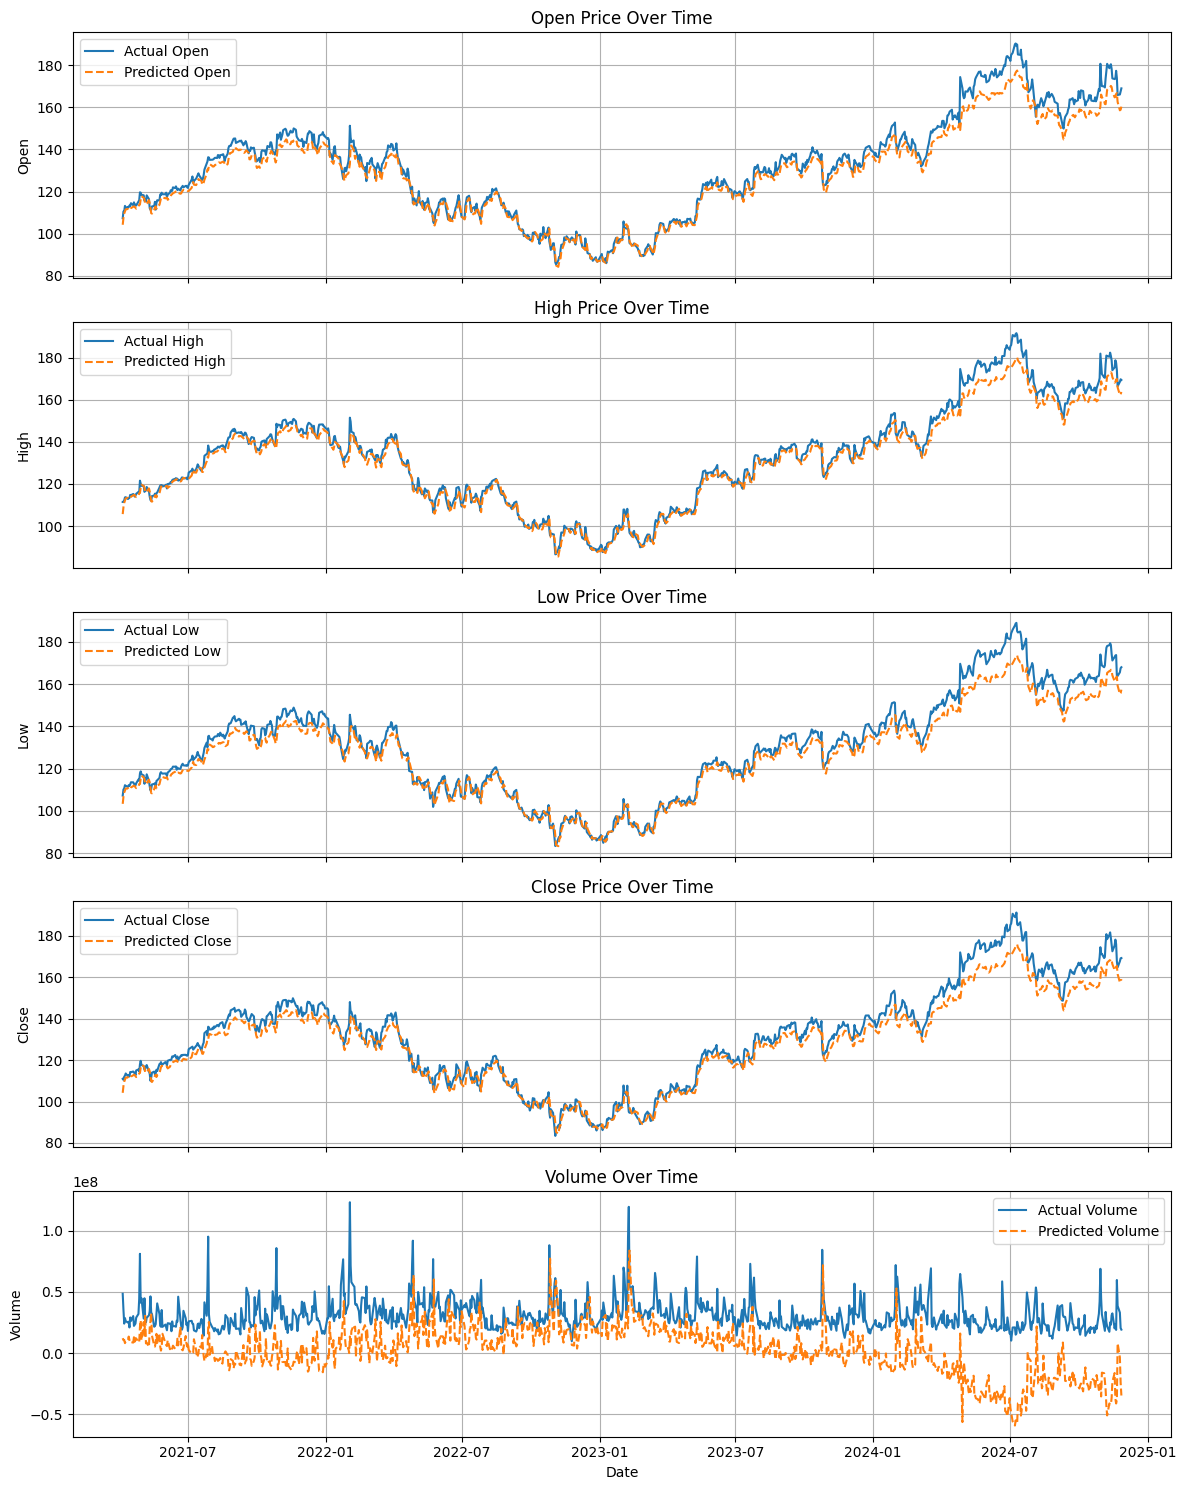

MSE Loss: 0.00279
Variance: 0.41586
The model performs better than a mean-based prediction.


In [7]:
model.eval()
test_loss = 0.0
predictions = []
actuals = []
mse_per_feature = [0.0] * output_size  # MSE for each feature
variance_per_feature = [0.0] * output_size  # Variance for each feature

# Disable gradient computation for evaluation
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output, _ = model.forward(x_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item()
        predictions.append(output.cpu())
        actuals.append(y_batch.cpu())
        
        # Compute MSE and variance for each feature
        for i in range(output_size):
            mse_per_feature[i] += nn.functional.mse_loss(output[:, i], y_batch[:, i], reduction='sum').item()
            variance_per_feature[i] += torch.sum((y_batch[:, i] - torch.mean(y_batch[:, i]))**2).item()

# Calculate average test loss
test_loss /= len(test_loader) 
print(f"Test Loss: {test_loss:.5f}")

# Average MSE and Variance over the dataset
num_samples = len(test_loader)
mse_per_feature = [mse / num_samples for mse in mse_per_feature]
variance_per_feature = [var / num_samples for var in variance_per_feature]

# Post-processing predictions and actuals for inverse scaling
predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# Split predictions and actuals into two parts: one for OHLC and one for Volume
predictions_ohlc = predictions[:, :4]  # First 4 columns are OHLC
predictions_volume = predictions[:, [4]]  # Last column is Volume

actuals_ohlc = actuals[:, :4]
actuals_volume = actuals[:, [4]]

# Inverse transform OHLC using pp.scaler
predictions_ohlc_original = pp.scaler.inverse_transform(predictions_ohlc)
actuals_ohlc_original = pp.scaler.inverse_transform(actuals_ohlc)

# Inverse transform Volume using pp.volume_scaler
predictions_volume_original = pp.volume_scaler.inverse_transform(predictions_volume)
actuals_volume_original = pp.volume_scaler.inverse_transform(actuals_volume)

# Combine OHLC and Volume back into the final format
predictions_original = np.hstack([predictions_ohlc_original, predictions_volume_original])
actuals_original = np.hstack([actuals_ohlc_original, actuals_volume_original])

# Print and compare MSE and Variance for each feature
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
print("\nComparison of MSE and Variance for each feature:")
for i, (mse, var) in enumerate(zip(mse_per_feature, variance_per_feature)):
    print(f"{feature_names[i]}: MSE = {mse:.5f}, Variance = {var:.5f}")
    if mse < var:
        print(f"  -> The model performs better than a mean-based prediction for {feature_names[i]}.")
    else:
        print(f"  -> The model does not outperform a mean-based prediction for {feature_names[i]}.")

# Print sample predictions and actual values
for i in range(5):
    print(f"Date: {y_test_dates[i]}")
    prediction_str = ", ".join([f"{x:.2f}" for x in predictions_original[i]])
    actual_str = ", ".join([f"{x:.2f}" for x in actuals_original[i]])
    print(f"Sample prediction (original scale): {prediction_str}")
    print(f"Actual values (original scale): {actual_str}")
    print("-" * 50)

# Plotting results
plotter = DataPlotter()
df_results = plotter.create_results_dataframe(y_test_dates, actuals_original, predictions_original)
plotter.plot_results(df_results)

variance = np.var(actuals)

# Print MSE loss and variance
print(f"MSE Loss: {test_loss:.5f}")
print(f"Variance: {variance:.5f}")

# Compare MSE loss with variance
if test_loss < variance:
    print("The model performs better than a mean-based prediction.")
else:
    print("The model does not perform better than a mean-based prediction.")